# RoPE 位置编码衰减性实验分析

为了描述词之间的位置关系，需要对词向量嵌入位置编码，使其区分词的距离关系

- Transformer：使用绝对位置编码
- Llama： 使用旋转位置编码（RoPE）

假设越近的文本关联性越大，越远的关联性越小，两个词向量位置越远，其位置编码经过运算(乘积)应当越小

好的位置编码直觉
- 衰减曲线应该平滑，而非突兀的变化
- 在长距离下应当能有区分的表示，位置1和10000之间的距离差值应当1和10000000之间有差异

在transforemrs里实现RoPE、PI-RoPE 和 NTK-RoPE，4096长度下三种RoPE符合衰减规律，64000长度下除NTK-RoPE，已经不满足衰减了，自然长度就无法推出去

![rope-decay](./image/rope-decay.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(42)

# 带距离分数的注意力计算

In [2]:
d = 4
l = 4
q = torch.randn(1,d)
k = torch.randn(l,d)
v = torch.randn(l,d)
s = 1.0 / torch.tensor([range(1,1+d)])
print(s)
shift = [3,2,1,0]

tensor([[1.0000, 0.5000, 0.3333, 0.2500]])

In [3]:
# 不带相对位置注意力计算
q_attn = F.softmax(q@k.transpose(1,0),dim=1)@v
print('original order:',q_attn)
k_shift = k[shift,:]
v_shift = v[shift,:]
q_attn = F.softmax(q@k_shift.transpose(1,0),dim=1)@v_shift
print('shift order:',q_attn)

original order: tensor([[-0.3948, -0.2424, -0.7260,  0.0862]])

shift order: tensor([[-0.3948, -0.2424, -0.7260,  0.0862]])

In [4]:
# 带相对位置注意力计算
q_attn = F.softmax(s * q @ k.transpose(1,0), dim=1) @ v
print('original order with score:', q_attn)
k_shift = k[shift,:] 
v_shift = v[shift,:]
s_shift = s[:,shift]
q_attn = F.softmax(s_shift * q @ k_shift.transpose(1,0), dim=1) @ v_shift
print('shift order with score:', q_attn) 

original order with score: tensor([[-0.3461, -0.2727, -0.7590,  0.0982]])

shift order with score: tensor([[-0.4436, -0.2411, -0.7497, -0.0448]])

# 绝对位置编码实现

In [39]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=512, max_len=1024, base=10000.0, pi=1.0, device='cpu'):
        '''
            pi: position interploation, pi > 1.0
            ntk: position interploation, base > 10000.0
        '''
        
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  
        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        _2i = torch.arange(0, d_model, step=2, device=device).float()

        # # ntk-rope
        # a = 8
        # base = base * a ** (dim / (dim-2)) 
        self.theta = torch.sin(pos / (pi * (base ** (_2i / d_model))))
        self.encoding[:, 0::2] = torch.sin(pos / (pi * (base ** (_2i / d_model))))
        self.encoding[:, 1::2] = torch.cos(pos / (pi * (base ** (_2i / d_model))))
        # 512
        # 2x256 cos sin
        
    def forward(self, x):
        batch_size, seq_len = x.size()
        return self.encoding[:seq_len, :]


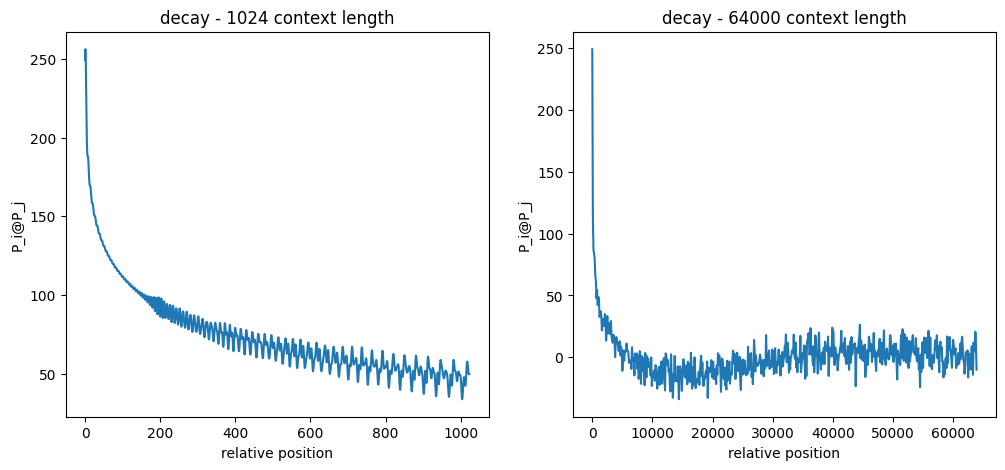

In [17]:
# 绝对位置衰减实验
d_model = 512
max_len = 1024
x1 = range(max_len)
pe = PositionalEncoding(d_model, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_1024 = result.tolist()

max_len = 64000
x2 = range(max_len)
pe = PositionalEncoding(d_model, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_64000 = result.tolist()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
step = 100
ax1.plot(x1, result_1024)
ax1.set_title("decay - 1024 context length")
ax1.set_xlabel("relative position")
ax1.set_ylabel("P_i@P_j")

ax2.plot(x2[::step], result_64000[::step])
ax2.set_title("decay - 64000 context length")
ax2.set_xlabel("relative position")
ax2.set_ylabel("P_i@P_j")

# 显示图像
plt.show()
del result_64000
del result_1024

# 绝对位置1024长度 PI/NTK 衰减性实验

In [3]:
d_model = 512
max_len = 1024
device = 'cpu'

x = range(max_len)

pe = PositionalEncoding(d_model, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_base = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=100000.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_100000 = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=1000000.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_1000000 = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=2.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_pi_2 = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=4.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_pi_4 = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=10000.0, pi=2.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_ntk5_pi_2 = result.tolist()

绝对位置编码base版本在200之前稳定平滑下降，随后出现震荡

震荡在一定长度，1-1000的距离权重 < 1-1005的距离权重,

意味着1000和1005的距离权重并不是我们所理想的

产生此现象的结果是由于sin和cos本身具有周期性

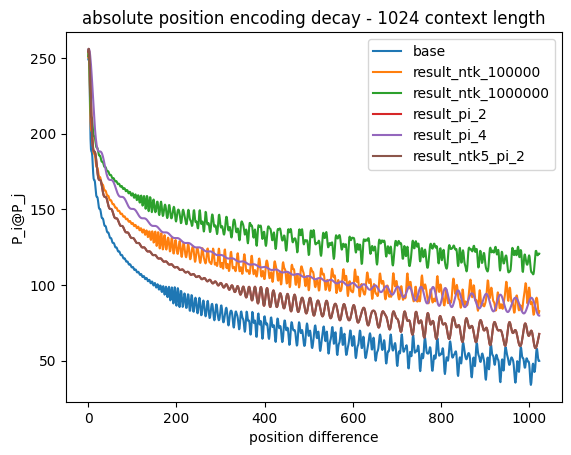

In [4]:
plt.plot(x, result_base, label = 'base' )
plt.plot(x, result_ntk_100000, label = 'result_ntk_100000' )
plt.plot(x, result_ntk_1000000, label = 'result_ntk_1000000')
plt.plot(x, result_pi_2, label = 'result_pi_2')
plt.plot(x, result_pi_4, label = 'result_pi_4')
plt.plot(x, result_ntk5_pi_2, label = 'result_ntk5_pi_2')

plt.title("absolute position encoding decay - 1024 context length")
plt.xlabel("position difference")
plt.ylabel("P_i@P_j")
plt.legend()
plt.show()

In [ ]:
del result_base
del result_ntk_100000
del result_ntk_1000000
del result_pi_2
del result_pi_4
del result_ntk5_pi_2

# 增大维度

维度越大，位置编码衰减性越好

In [76]:
d_model = 8192 # 512 -> 8192
max_len = 1024 
device = 'cpu'

x = range(max_len)

pe = PositionalEncoding(512, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_512 = result.tolist()

pe = PositionalEncoding(1024, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_1024 = result.tolist()

pe = PositionalEncoding(2048, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_2048 = result.tolist()

pe = PositionalEncoding(4096, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_4096 = result.tolist()

pe = PositionalEncoding(8192, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_8192 = result.tolist()

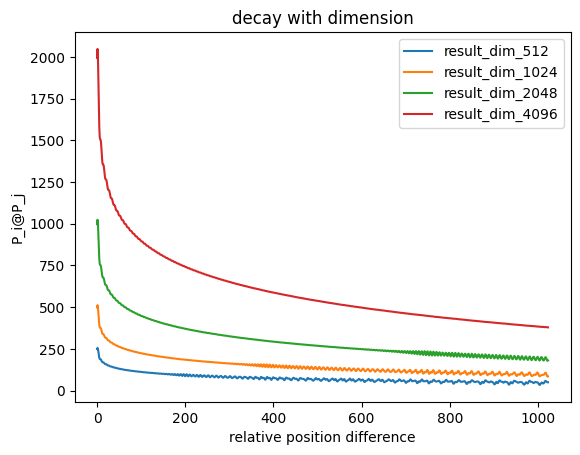

In [77]:
plt.plot(x, result_512, label = 'result_dim_512' )
plt.plot(x, result_1024, label = 'result_dim_1024')
plt.plot(x, result_2048, label = 'result_dim_2048')
plt.plot(x, result_4096, label = 'result_dim_4096')
# plt.plot(x, result_8192, label = 'result_8192')

plt.title("decay with dimension")
plt.xlabel("relative position difference")
plt.ylabel("P_i@P_j")
plt.legend()
plt.show()

In [ ]:
del result_512
del result_1024
del result_2048
del result_4096

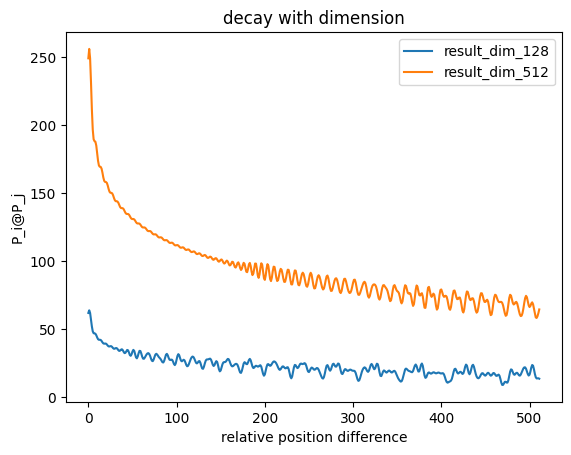

In [42]:
d_model = 8192 # 512 -> 8192
max_len = 512 
device = 'cpu'

x = range(max_len)

pe = PositionalEncoding(128, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_128 = result.tolist()


pe = PositionalEncoding(512, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_512 = result.tolist()

plt.plot(x, result_128, label = 'result_dim_128' )
plt.plot(x, result_512, label = 'result_dim_512' )
# plt.plot(x, result_8192, label = 'result_8192')

plt.title("decay with dimension")
plt.xlabel("relative position difference")
plt.ylabel("P_i@P_j")
plt.legend()
plt.show()

In [ ]:
del result_512
del result_128

## 不同位置的为位置编码向量对比

256

torch.Size([1024, 512])

256

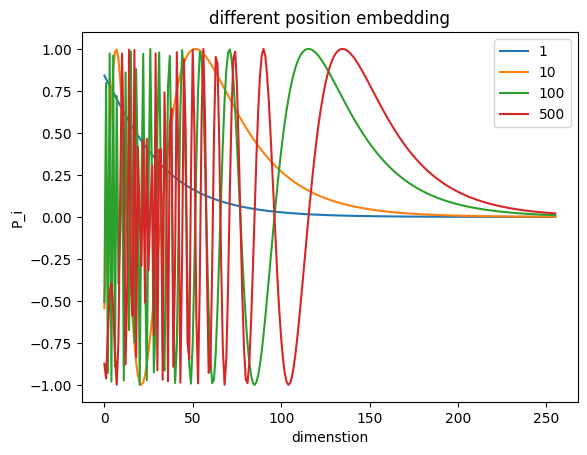

In [7]:
pe = PositionalEncoding(512, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_512 = result.tolist()


pe_a = pe[1,0::2].tolist()
pe_b = pe[10,0::2].tolist()
pe_c = pe[100,0::2].tolist()
pe_d = pe[200,0::2].tolist()
# x_d = x[0::2]
x_d = range(len(pe_a))
print(len(pe_a))
print(pe.shape)
print(len(x_d))

plt.plot(x_d, pe_a, label = '1' )
plt.plot(x_d, pe_b, label = '10')

plt.plot(x_d, pe_c, label = '100' )
plt.plot(x_d, pe_d, label = '500')
# # plt.plot(x, result_8192, label = 'result_8192')

plt.title("different position embedding")
plt.xlabel("dimenstion")
plt.ylabel("P_i")
plt.legend()
plt.show()

## 绝对位置编码-64000长度

In [18]:
d_model = 1024
max_len = 64000

x = range(max_len)

pe = PositionalEncoding(d_model, max_len).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_base = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=100000.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_100000 = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=1000000.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_1000000 = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=2.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_pi_2 = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=4.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_pi_4 = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=10000.0, pi=2.0).encoding
result = pe[1,:] @ pe.transpose(1,0)
result_ntk5_pi_2 = result.tolist()

将绝对位置编码长度拉到64000，base的曲线已经没有衰减的规律了

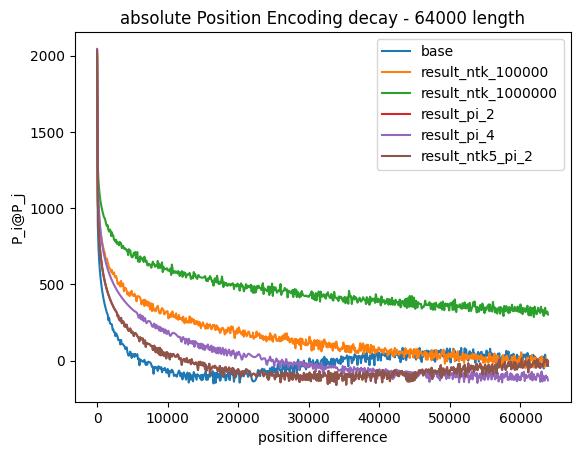

In [8]:
step = 100
x_s = x[::step]
plt.plot(x_s, result_base[::step], label = 'base' )
plt.plot(x_s, result_ntk_100000[::step], label = 'result_ntk_100000' )
plt.plot(x_s, result_ntk_1000000[::step], label = 'result_ntk_1000000')
plt.plot(x_s, result_pi_2[::step], label = 'result_pi_2')
plt.plot(x_s, result_pi_4[::step], label = 'result_pi_4')
plt.plot(x_s, result_ntk5_pi_2[::step], label = 'result_ntk5_pi_2')
plt.legend()

plt.title(f"absolute Position Encoding decay - {max_len} length")
plt.xlabel("position difference")
plt.ylabel("P_i@P_j")
plt.show()


In [ ]:
del result_base
del result_ntk_100000
del result_ntk_1000000
del result_pi_2
del result_pi_4
del result_ntk5_pi_2

# 高频低频衰减性测试

In [11]:
pe.shape
d_model/2

2048.0

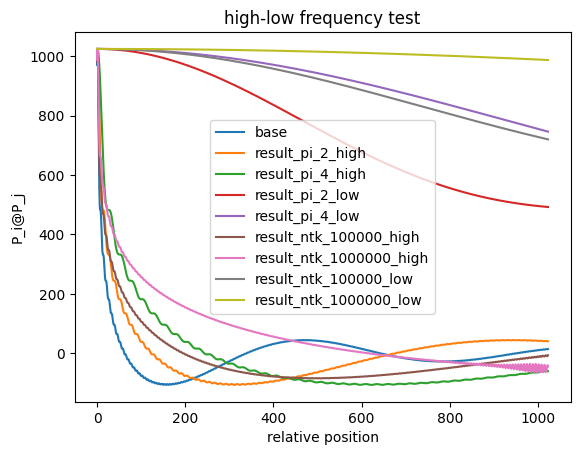

In [12]:

d_model = 4096
max_len = 1024
d_tmp = int(d_model/2.0)

x = range(max_len)

pe = PositionalEncoding(d_model, max_len).encoding
pe = pe[:, :d_tmp]
result = pe[1,:] @ pe.transpose(1,0)
result_base = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=2.0).encoding
pe = pe[:, :d_tmp]
result = pe[1,:] @ pe.transpose(1,0)
result_pi_2_high = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=4.0).encoding
pe = pe[:, :d_tmp]
result = pe[1,:] @ pe.transpose(1,0)
result_pi_4_high = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=2.0).encoding
pe = pe[:, d_tmp:]
result = pe[1,:] @ pe.transpose(1,0)
result_pi_2_low = result.tolist()

pe = PositionalEncoding(d_model, max_len, pi=4.0).encoding
pe = pe[:, d_tmp:]
result = pe[1,:] @ pe.transpose(1,0)
result_pi_4_low = result.tolist()


pe = PositionalEncoding(d_model, max_len, base=100000.0).encoding
pe = pe[:, :d_tmp]
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_100000_high = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=1000000.0).encoding
pe = pe[:, :d_tmp]
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_1000000_high = result.tolist()


pe = PositionalEncoding(d_model, max_len, base=100000.0).encoding
pe = pe[:, d_tmp:]
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_100000_low = result.tolist()

pe = PositionalEncoding(d_model, max_len, base=1000000.0).encoding
pe = pe[:, d_tmp:]
result = pe[1,:] @ pe.transpose(1,0)
result_ntk_1000000_low = result.tolist()


step = 1
x_s = x[::step]
plt.plot(x_s, result_base[::step], label = 'base' )
plt.plot(x_s, result_pi_2_high[::step], label = 'result_pi_2_high')
plt.plot(x_s, result_pi_4_high[::step], label = 'result_pi_4_high')
plt.plot(x_s, result_pi_2_low[::step], label = 'result_pi_2_low')
plt.plot(x_s, result_pi_4_low[::step], label = 'result_pi_4_low')
plt.plot(x_s, result_ntk_100000_high[::step], label = 'result_ntk_100000_high')
plt.plot(x_s, result_ntk_1000000_high[::step], label = 'result_ntk_1000000_high')
plt.plot(x_s, result_ntk_100000_low[::step], label = 'result_ntk_100000_low')
plt.plot(x_s, result_ntk_1000000_low[::step], label = 'result_ntk_1000000_low')
plt.legend()

plt.title(f"high-low frequency test")
plt.xlabel("relative position")
plt.ylabel("P_i@P_j")
plt.show()


In [ ]:

del result_base
del result_pi_2_high
del result_pi_4_high
del result_pi_2_low
del result_pi_4_low
del result_ntk_100000_high
del result_ntk_1000000_high
del result_ntk_100000_low
del result_ntk_1000000_low

# RoPE-Base-NTK-PI对比

应用较广的RoPE位置编码主要有三个RoPE、PI、NTK版本

使用Transformers库Llama 位置编码实现，进行衰减性分析

In [2]:
#./huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py

from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding
from transformers.models.llama.modeling_llama import LlamaDynamicNTKScalingRotaryEmbedding
from transformers.models.llama.modeling_llama import LlamaLinearScalingRotaryEmbedding
from transformers.models.llama.modeling_llama import rotate_half, apply_rotary_pos_emb

In [3]:
# d_model = 4096
# max_len = 64000
d_model = 4096
max_len = 64000

Q = torch.ones(1,1,max_len, d_model)
K = torch.ones(1,1,max_len, d_model)
position_ids = torch.tensor([range(max_len)], dtype=torch.long)

In [7]:
rotary_emb = LlamaRotaryEmbedding(
                d_model,
                max_position_embeddings=max_len,
                base=10000.0,
            )
pi_emb = LlamaLinearScalingRotaryEmbedding(
                d_model,
                max_position_embeddings=max_len,
                scaling_factor=2.0,
                base=10000.0,
            )
ntk_emb = LlamaDynamicNTKScalingRotaryEmbedding(
                d_model,
                max_position_embeddings=1.0,
                scaling_factor=8.0,
                base=10000.0,
            )
def call_rope_result(Q, position_ids, fn_rope_emb): 
    cos, sin = fn_rope_emb(Q, position_ids)
    Q_rope, K_rope = apply_rotary_pos_emb(Q, K, cos, sin)
    result_rope = Q_rope[0,0,[0]] @ K_rope[0,0,:,:].transpose(1,0)
    result_rope = result_rope[0].tolist()
    return result_rope


In [8]:
result_rope_base = call_rope_result(Q, position_ids, rotary_emb)
result_rope_ntk = call_rope_result(Q, position_ids, ntk_emb)
result_rope_pi = call_rope_result(Q, position_ids, pi_emb)
x = range(max_len)

4096长度下，RoPE衰减的较PE理想

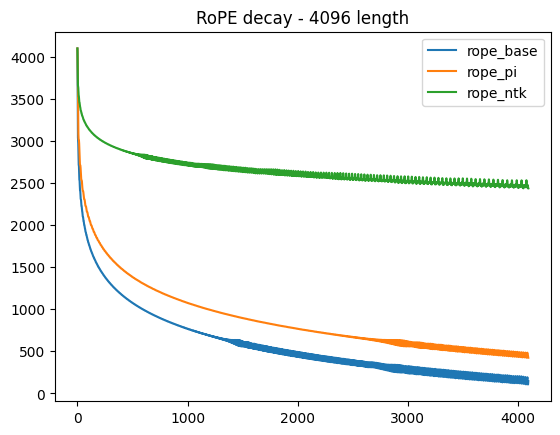

In [9]:
# 观察4096长度下的RoPE
x_s = x[:4096:]
plt.plot(x_s, result_rope_base[:4096:], label = 'rope_base' )
plt.plot(x_s, result_rope_pi[:4096:], label = 'rope_pi' )
plt.plot(x_s, result_rope_ntk[:4096:], label = 'rope_ntk' )
plt.legend()
plt.title(f"RoPE decay - 4096 length")
plt.show()

拉到64000长度上

NTK在长距离下较RoPE和PI有更区分度，且符合衰减规律

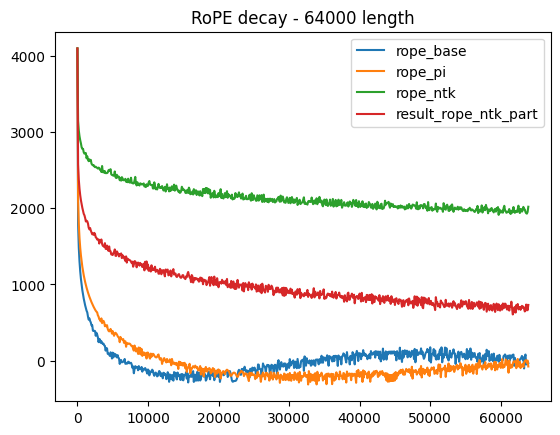

In [10]:
step = 100
x_s = x[::step]
plt.plot(x_s, result_rope_base[::step], label = 'rope_base' )
plt.plot(x_s, result_rope_pi[::step], label = 'rope_pi' )
plt.plot(x_s, result_rope_ntk[::step], label = 'rope_ntk' )
# plt.plot(x_s, result_rope_ntk_part[::step], label = 'result_rope_ntk_part' )
plt.legend()
plt.title(f"RoPE decay - 64000 length")
plt.show()

In [ ]:
del result_rope_base
del result_rope_pi
del result_rope_ntk

# 震荡性实验

In [19]:
ntk_emb_10000 = LlamaDynamicNTKScalingRotaryEmbedding(
                d_model,
                max_position_embeddings=4096,
                scaling_factor=8.0,
                base=10000.0,
            )

ntk_emb_1000 = LlamaDynamicNTKScalingRotaryEmbedding(
                d_model,
                max_position_embeddings=128,
                scaling_factor=1.0,
                base=1000.0,
            )

pi_emb_100 = LlamaLinearScalingRotaryEmbedding(
                d_model,
                max_position_embeddings=4096,
                scaling_factor=100.0,
                base=10000.0,
            )


pi_emb_2 = LlamaLinearScalingRotaryEmbedding(
                d_model,
                max_position_embeddings=4096,
                scaling_factor=2.0,
                base=10000.0,
            )


def call_rope_result(Q, position_ids, fn_rotary_emb): 
    cos, sin = fn_rotary_emb(Q, position_ids)
    Q_rope, K_rope = apply_rotary_pos_emb(Q, K, cos, sin)
    result_rope = Q_rope[0,0,[0]] @ K_rope[0,0,:,:].transpose(1,0)
    result_rope = result_rope[0].tolist()
    return result_rope

result_rope_pi_100 = call_rope_result(Q, position_ids, pi_emb_100)
result_rope_pi_2 = call_rope_result(Q, position_ids, pi_emb_2)
result_ntk_base = call_rope_result(Q, position_ids, ntk_emb_10000)
result_ntk_base_small = call_rope_result(Q, position_ids, ntk_emb_1000)
x = range(max_len)

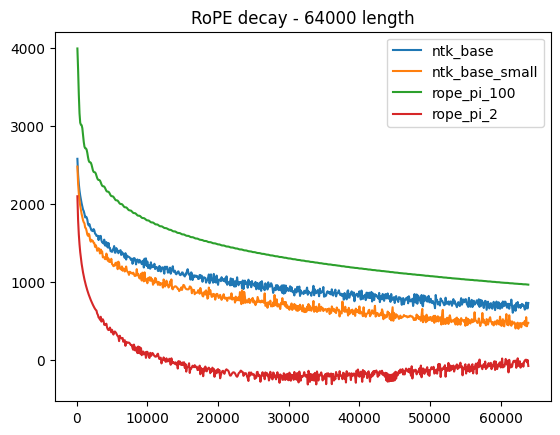

In [22]:
step = 100
start = 100
x_s = x[start::step]
plt.plot(x_s, result_ntk_base[start::step], label = 'ntk_base' )
plt.plot(x_s, result_ntk_base_small[start::step], label = 'ntk_base_small' )
plt.plot(x_s, result_rope_pi_100[start::step], label = 'rope_pi_100' )
plt.plot(x_s, result_rope_pi_2[start::step], label = 'rope_pi_2' )
plt.legend()
plt.title(f"RoPE decay - 64000 length")
plt.show()

In [ ]:
del result_ntk_base
del result_ntk_base_small
del result_rope_pi_100
del result_rope_pi_2

# 内插

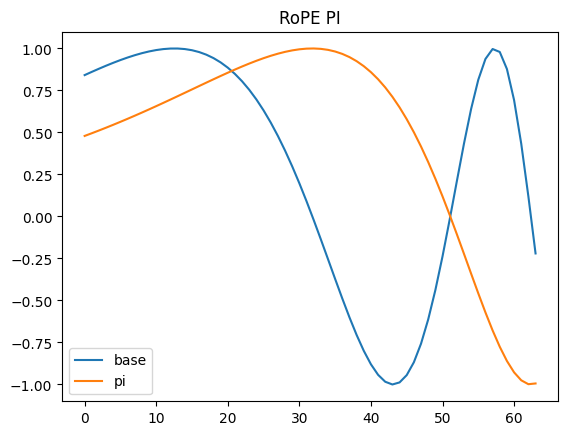

In [15]:
d = 256
x = range(d)
x_t = 10000.0**(-torch.tensor(x)/d)
y = torch.sin(1/x_t).tolist()
y_pi = torch.sin(1/(2*x_t)).tolist()

# x_s = x[start::step]
plt.plot(x[:64:], y[:64:], label = 'base' )
plt.plot(x[:64:], y_pi[:64:], label = 'pi')
plt.legend()
plt.title(f"RoPE PI")
plt.show()

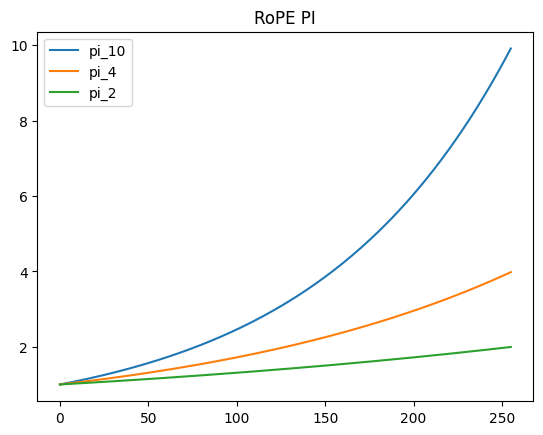

In [21]:
d = 256
# pi_scale = 10.0
x = range(d)
x_t_10 = 10.0**(torch.tensor(x)/d)
x_t_4 = 4.0**(torch.tensor(x)/d)
x_t_2 = 2.0**(torch.tensor(x)/d)

plt.plot(x,x_t_10, label = 'pi_10' )
plt.plot(x,x_t_4, label = 'pi_4' )
plt.plot(x,x_t_2, label = 'pi_2' )
plt.legend()
plt.title(f"RoPE PI")
plt.show()

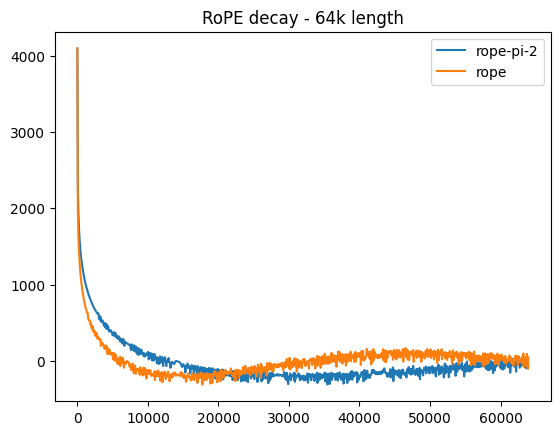

In [37]:
result_64000
result_base

step = 64
x_s = x[::step]
plt.plot(x_s, result_rope_pi[::step], label = 'rope-pi-2' )
plt.plot(x_s, result_rope_base[::step], label = 'rope' )
plt.legend()
plt.title(f"RoPE decay - 64k length")
plt.show()